In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple

In [4]:
class SARSA():
    def __init__(self, env, num_episodes, discount=1.0, alpha=0.5, epsilon=0.1, n_bins=10):
        self.nA = env.action_space.n
        self.nS = env.observation_space.shape[0]
        self.env = env
        self.num_episodes = num_episodes
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        
        # Keeps track of useful statistics
        record = namedtuple("Record", ["episode_lengths","episode_rewards"])
        self.rec = record(episode_lengths=np.zeros(num_episodes),
                          episode_rewards=np.zeros(num_episodes))
        
        self.cart_position_bins = pd.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1]
        self.pole_angle_bins = pd.cut([-2, 2], bins=n_bins, retbins=True)[1]
        self.cart_velocity_bins = pd.cut([-1, 1], bins=n_bins, retbins=True)[1]
        self.angle_rate_bins = pd.cut([-3.5, 3.5], bins=n_bins, retbins=True)[1]
        
    def get_bins_states(self, state):
        """
        Case number of the sate is huge so in order to simplify the situation 
        cut the state sapece in to bins.
        
        if the state_idx is [1,3,6,4] than the return will be 1364
        """
        s1_, s2_, s3_, s4_ = state
        cart_position_idx = np.digitize(s1_, self.cart_position_bins)
        pole_angle_idx = np.digitize(s2_, self.pole_angle_bins)
        cart_velocity_idx = np.digitize(s3_, self.cart_velocity_bins)
        angle_rate_idx = np.digitize(s4_, self.angle_rate_bins)
        
        state_ = [cart_position_idx, pole_angle_idx, 
                  cart_velocity_idx, angle_rate_idx]
        
        state = map(lambda s: int(s), state_)
        return tuple(state)
        
    def epislon_greedy_policy(self, epsilon, nA):

        def policy(state):
            A = np.ones(nA, dtype=float) * epsilon / nA
            best_action = np.argmax(self.Q[state])
            A[best_action] += (1.0 - epsilon)
            return A

        return policy

    def next_action(self, prob):
        return np.random.choice(np.arange(len(prob)), p=prob)


In [6]:
sarsa = SARSA(env, 100)
# 每个特征被按照其取值范围，被分成了10等长区间，得到11个分界点
print(sarsa.cart_position_bins) # 小车所处的位置 x [-3.5, 3.5]
print(sarsa.pole_angle_bins) # 杆子的摇摆角度 d_theta [-2, 2]
print(sarsa.cart_velocity_bins) # 小车的速度 d_x [-1, 1]
print(sarsa.angle_rate_bins) # 杆子摇摆的角速度 theta [-2.4, 2.4]

[-2.4048 -1.92   -1.44   -0.96   -0.48    0.      0.48    0.96    1.44
  1.92    2.4   ]
[-2.004 -1.6   -1.2   -0.8   -0.4    0.     0.4    0.8    1.2    1.6
  2.   ]
[-1.002 -0.8   -0.6   -0.4   -0.2    0.     0.2    0.4    0.6    0.8
  1.   ]
[-3.507 -2.8   -2.1   -1.4   -0.7    0.     0.7    1.4    2.1    2.8
  3.5  ]


In [25]:
sarsa = SARSA(env, 1000)
state = env.reset() # state: [x, theta, d_x, d_theta]
print(state) # 获取状态的数值形式
bins_state = sarsa.get_bins_states(state)
print(bins_state) # 获取状态的离散id形式

[0.01027124 0.04037298 0.00300505 0.02004855]
(6, 6, 6, 6)


In [49]:
def epislon_greedy_policy(action_values, state, epislon=0.1):
    state_action_values = action_values[state]
    nA = state_action_values.shape[0]
    action_prob = np.ones((nA), dtype=np.float32) * epislon / nA
    action_prob[np.argmax(state_action_values)] = 1 - epislon + epislon / nA
    return np.random.choice(np.arange(nA), p=action_prob)


def sarsa_core(env, max_episodes, learning_rate=0.5, discount=1.0, epislon= 0.1, state_key_fun=None):
    nA = env.action_space.n
    action_values = defaultdict(lambda: np.zeros(nA, dtype=np.float32))
    record = namedtuple("Record", ["episode_steps", "episode_rewards"])
    record.episode_steps = []
    record.episode_rewards = []
    if(state_key_fun == None):
        state_key_fun = lambda x: x
    "对每一个终止状态的所有动作价值函数设置为0"
    "终止状态："
    for episode in range(max_episodes):
        state = env.reset()
        "1. 根据动作价值函数的epislon贪婪法选择当前状态下的动作"
        action = epislon_greedy_policy(action_values, state_key_fun(state), epislon)
        total_step = 0
        total_reward = 0
        while(True):
            "1.1 执行一个单步操作"
            next_state, reward, done, _ = env.step(action)
            # 将价值所对应的键值转化为方便映射的键值
            state_key, next_state_key = state_key_fun(
                state), state_key_fun(next_state)
            "1.2 根据动作价值函数的epislon贪婪法选择下一个状态下的动作"
            next_action = epislon_greedy_policy(
                action_values, next_state_key, epislon)
            "1.3 单步更新动作价值函数"
            next_gain = reward + discount * action_values[next_state_key][next_action]
            td_delta = next_gain - action_values[state_key][action]
            action_values[state_key][action] += learning_rate * td_delta
            # 进行调试记录
            total_step += 1
            total_reward += reward
            if(done):
                break
            state = next_state
            action = next_action

        record.episode_steps.append(total_step)
        record.episode_rewards.append(total_reward)
        if(episode%10==0):
                print("episode: %d, step: %.2f , sum reward: %.2f" % (episode, total_step, total_reward))

    return action_values, record

In [50]:
class CartPole_Sarsa():
    def __init__(self, env, max_episodes, learning_rate=0.5, discount=1.0, n_bins=10):
        self.env = env
        self.max_episodes = max_episodes
        self.learning_rate = learning_rate
        self.discount = discount

        self.cart_position_bins = pd.cut(
            [-2.4, 2.4], bins=n_bins, retbins=True)[1]
        self.pole_angle_bins = pd.cut([-2, 2], bins=n_bins, retbins=True)[1]
        self.cart_velocity_bins = pd.cut([-1, 1], bins=n_bins, retbins=True)[1]
        self.angle_rate_bins = pd.cut(
            [-3.5, 3.5], bins=n_bins, retbins=True)[1]

    def get_bins_states(self, state):
        s1_, s2_, s3_, s4_ = state
        cart_position_idx = np.digitize(s1_, self.cart_position_bins)
        pole_angle_idx = np.digitize(s2_, self.pole_angle_bins)
        cart_velocity_idx = np.digitize(s3_, self.cart_velocity_bins)
        angle_rate_idx = np.digitize(s4_, self.angle_rate_bins)

        state_ = [cart_position_idx, pole_angle_idx,
                  cart_velocity_idx, angle_rate_idx]

        state = map(lambda s: int(s), state_)
        return tuple(state)

    def sarsa(self):
        return sarsa_core(self.env, self.max_episodes, \
        self.learning_rate, self.discount, state_key_fun=self.get_bins_states)

In [51]:
env_name = "CartPole-v0"
env = gym.make(env_name)
sarsa = CartPole_Sarsa(env, 100)
action_values, record = sarsa.sarsa()

episode: 0, step: 9.00 , sum reward: 9.00
episode: 10, step: 12.00 , sum reward: 12.00
episode: 20, step: 8.00 , sum reward: 8.00
episode: 30, step: 14.00 , sum reward: 14.00
episode: 40, step: 8.00 , sum reward: 8.00
episode: 50, step: 12.00 , sum reward: 12.00
episode: 60, step: 11.00 , sum reward: 11.00
episode: 70, step: 11.00 , sum reward: 11.00
episode: 80, step: 79.00 , sum reward: 79.00
episode: 90, step: 26.00 , sum reward: 26.00


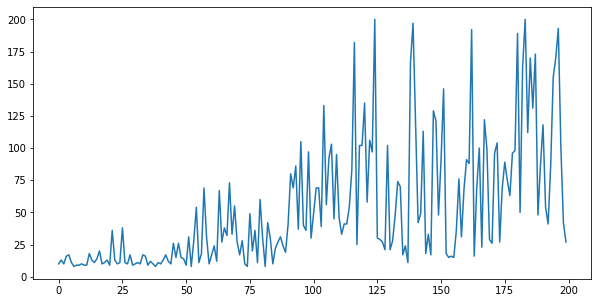

In [35]:
fig1 = plt.figure(figsize=(10,5))
plt.plot(record.episode_steps[:200])
plt.show(fig1)

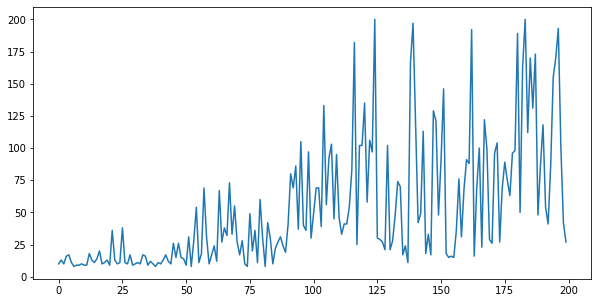

In [36]:
fig2 = plt.figure(figsize=(10,5))
plt.plot(record.episode_rewards[:200])
plt.show(fig2)